<a href="https://colab.research.google.com/github/IEXE-Tec/mcda-marketing/blob/main/03_sistema_de_recomendacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este colab esta basado en las notas y codigo de Jill Cates:   
+ Video: https://www.youtube.com/watch?v=v_mONWiFv0k&t=1281s  
+ Github: https://github.com/topspinj/recommender-tutorial 

# Recomendador Item-Item o Producto-Producto


Si has usado Netflix, Amazon Prime o algun servicio de streaming de peliculas online seguro has notado la seccion "Por que viste la Pelicula X ... ". Esta seccion nos da recomendaciones de peliculas que podrian gustarnos basandose en peliculas que ya hemos visto.  

En esta primera parte del laboratorio desarrollaremos un sistema de recomendacion item-item usando [filtrado colaborativo](https://es.wikipedia.org/wiki/Filtrado_colaborativo).

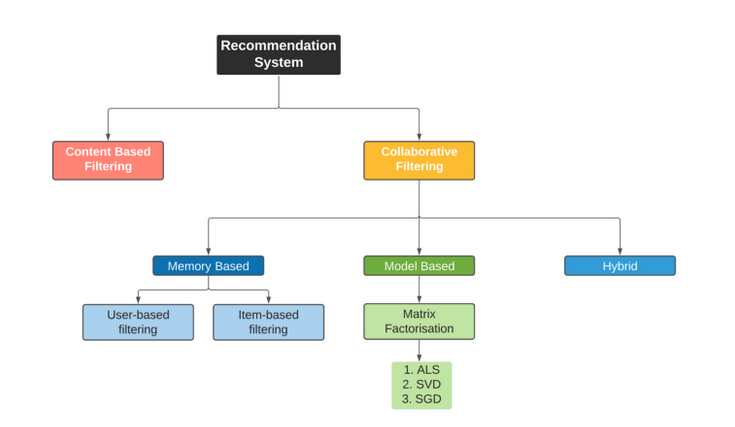

In [171]:
! pip install fuzzywuzzy

In [173]:
! pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.7MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149807 sha256=21e41e08d3059db059273ee7abaf6bcdbd1632d9e8a67d20f64c1aad2f738030
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [215]:
! pip install implicit

     |████████████████████████████████| 1.1MB 5.1MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406314 sha256=a003713da610dfb614fc52b5c294354ef5eeac2071ed69291eae7d6c12998b46
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [217]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import implicit
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(16,6)})

## ETL



Descarguemos el data set [MovieLens](https://www.wikiwand.com/en/MovieLens). Lo podemos descargar desde un link directo, Amazon o desde github. Son dos bases: **ratings.csv** & **movies.csv**.  
+ **github**:
+ **amazon**:
  - https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
  - https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv
+ **directo**: [here](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

In [84]:
ratings = pd.read_csv("https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [85]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [86]:
movies = pd.read_csv("https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [87]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


## EDA

### Variables

Para esta primera parte del proyecto utilizaremos los `Ratings` de los usuarios. Exploremos las particularidades de cada variable.

In [88]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Numero de ratings: {n_ratings}")
print(f"Numero de movieId's unicos: {n_movies}")
print(f"Numero de usuarios unicos: {n_users}")
print(f"Numero promedio de ratings generados por usuario: {round(n_ratings/n_users, 2)}")
print(f"Numero promedio de ratings por pelicula: {round(n_ratings/n_movies, 2)}")

Numero de ratings: 100836
Numero de movieId's unicos: 9724
Numero de usuarios unicos: 610
Numero promedio de ratings generados por usuario: 165.3
Numero promedio de ratings por pelicula: 10.37


Ahora analisemos el comportamiento por usuario

In [89]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [90]:
user_freq.describe()

,userId,n_ratings
count,610.000000,610.000000
mean,305.500000,165.304918
std,176.236111,269.480584
min,1.000000,20.000000
25%,153.250000,35.000000
50%,305.500000,70.500000
75%,457.750000,168.000000
max,610.000000,2698.000000


+ En **promedio** cada usuario ha calificado 165 peliculas, esto es una buena noticia.  
+ Tenemos una **mediana** de 75, muy por abajo de la media, lo que quiere decir que nuestra distribucion tiene colas largas.
+ El usuario que ha calificado menos peliculas es 20, lo cual no esta nada mal.  

In [91]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Podemos obserbar que nuestros usuarios son lo que Jill llama optimistas. Veamos el percentil 25, de este podemos deducir que por lo menos el 75% de las calificaciones son mayores o iguales a 3.

Ahora analicemos las distribuciones

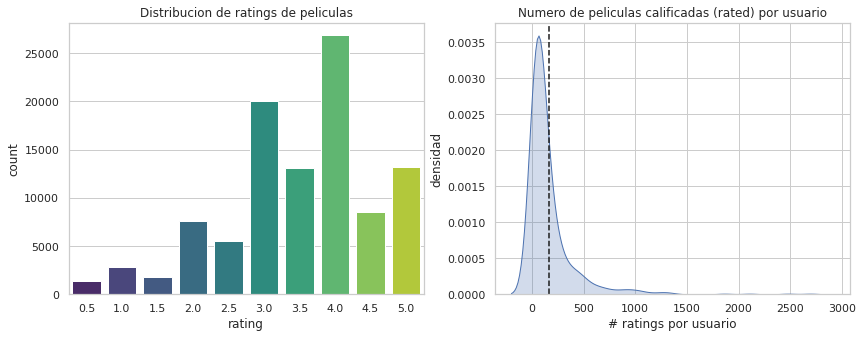

In [92]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribucion de ratings de peliculas")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings por usuario")
plt.ylabel("densidad")
plt.title("Numero de peliculas calificadas (rated) por usuario")
plt.show()

Podemos observar que nuestras calificacione so ratings estan sesgados hacia la izquierdam parece que las personas son bastante optimistas.

### Que peliculas tiene los ratings mas extremos?

In [93]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [94]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamerica es la pelicula con mejores calificaciones, pero cuantas calificaciones tiene?

In [95]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Podemos obserbar que Lamerica solo tiene dos calificaciones, lo que nos plantea el problema de tener muestras pequeñas. Recordemos que muestras pequeñas tiended a tener resultados extremos ya sea altos o bajos.



### Distribucion de Ratings

In [96]:
ratings_per_movie = ratings.groupby('movieId', as_index=False).agg({'rating':['count', 'mean', 'std']})
ratings_per_movie.columns = ['movieId', 'n_ratings', 'mean_ratings', 'std_ratings']
ratings_per_movie.head()

,movieId,n_ratings,mean_ratings,std_ratings
0,1,215,3.920930,0.834859
1,2,110,3.431818,0.881713
2,3,52,3.259615,1.054823
3,4,7,2.357143,0.852168
4,5,49,3.071429,0.907148


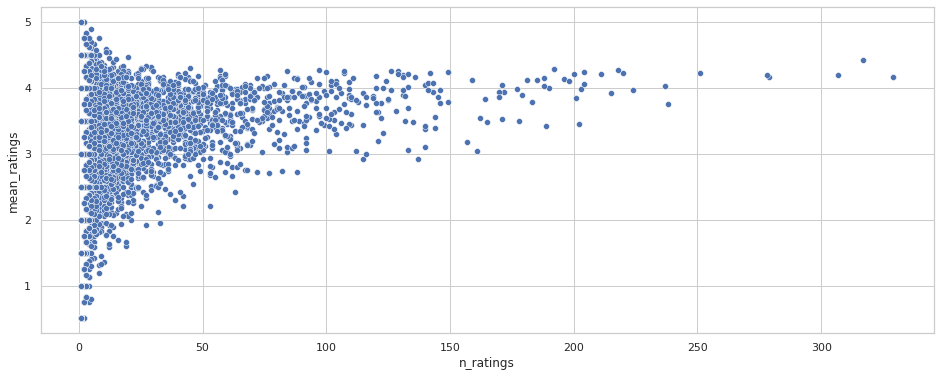

In [97]:
sns.scatterplot(data=ratings_per_movie, x='n_ratings', y='mean_ratings')

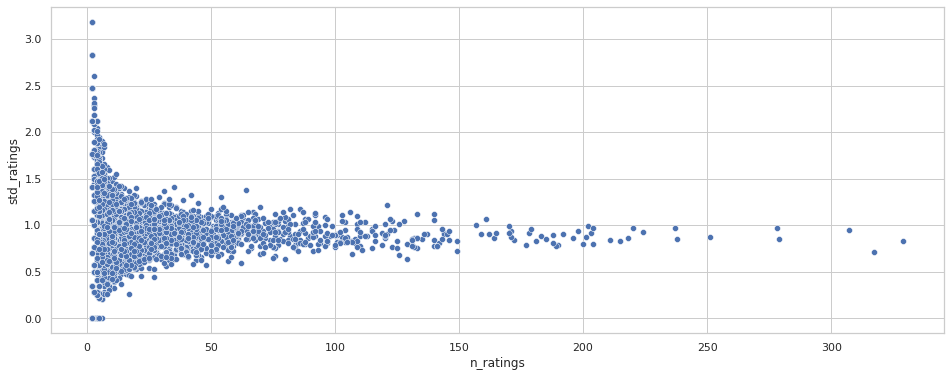

In [98]:
sns.scatterplot(data=ratings_per_movie, x='n_ratings', y='std_ratings')

Podemos observar como a menor numero de calificaciones mayor variacion, estre mas calificaciones tenemos menor varianza promedio. Esto corresponde con la hipotesis de que hay mas varianza con pocas calificaciones.  
Podemos ver a las pelicuals con pocas calificaciones como **outliers**. realmente no queremos que sesguen nuestro analisis, por lo que hay que tomar medidas.

Para controlar por este fenomeno y hacer a nuestro modelo mas robusto podemos utilizar el **Promedio Bayesiano** [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average).

### Bayesian Average




La media Bayesiana se define como:

$r_{i} = \frac{C \times m + \ \Sigma{ \ \text{reviews}}}{C+N}$  

+ $C:=$ representa cuanto valoramos nuestro valor inicial o confianza. Cuanto valoramos nuestras creencias (belief)?
+ $m:=$ representa nuestro prior. Cual creemos que es el valor real?
+ $N:=$ es el total de reviews para la pelicula $i$.  


Para nuestro modelos sugerimos que $m$ sea la media de nuestra muestra (`ratings['rating'].mean()`). Por la eleccion de nuestra prior, $C$ representa "el numero de observaciones de nuestro dataset". Entonces $C$ puede ser el numero promedio de ratings por pelicula, osea, cuantos calificaciones ne promedio tiene una pelicula.  

Podemos entender el promedio bayesiano como un promedio ponderado, donde el factor de ponderacion esta dado por el promedio de reviews en todas la peliculas $C$, mientras que la otra ponderacion esta dada por los reviews de la pelicula que estemos analizando $N$.  
$r_{i} = \frac{C \times m }{C+N} + \frac{\Sigma{ \ \text{reviews}}}{C+N}$  
  
$r_{i} = \frac{C}{C+N}\times m + \frac{N}{C+N}\times \mu_{reviews}$


In [99]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [100]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [101]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
# Diferencia entre media real y media bayesiana
movie_stats['diff'] = movie_stats['mean'] - movie_stats['bayesian_avg'] 
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title,diff
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)",0.036953
659,858,192,4.289062,4.236457,"Godfather, The (1972)",0.052606
2224,2959,218,4.272936,4.227052,Fight Club (1999),0.045884
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977),0.038430
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)",0.047178


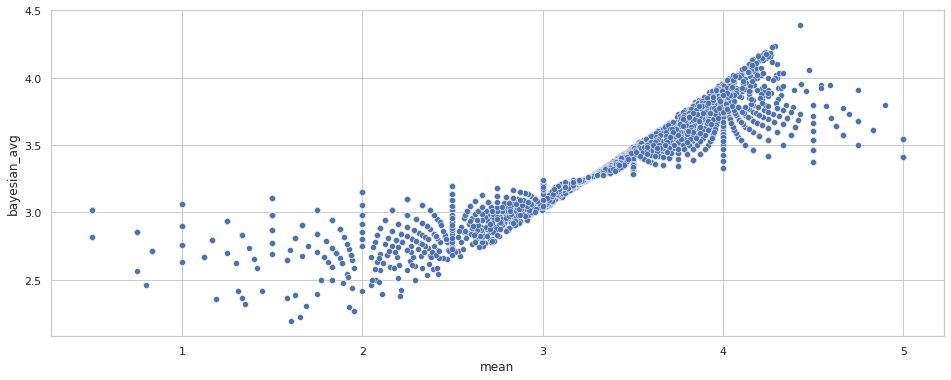

In [102]:
sns.scatterplot(data=movie_stats, x='mean', y='bayesian_avg')

Podemos observar que la relacion entre ambas es casi lineal, pero se ve distorsionada en peliculas con rating muy alto o bajo. Esto se debe a que los ratings extremos, ya sean altos o bajos estan relacionados a un numero bajo de observaciones.

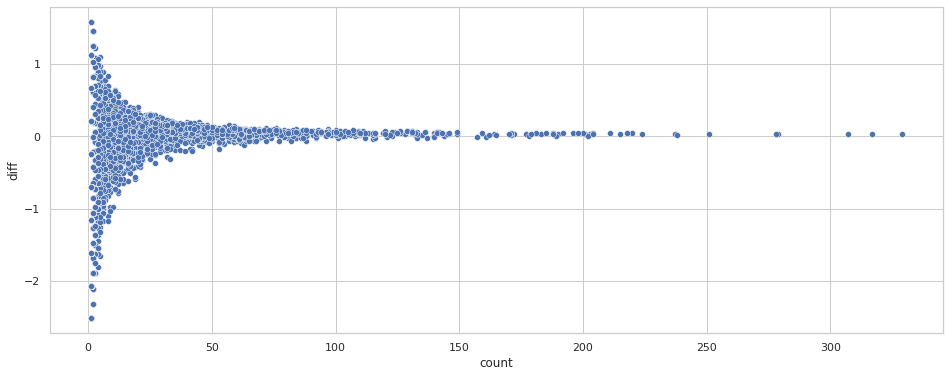

In [103]:
sns.scatterplot(data=movie_stats, x='count', y='diff')

Podemos observar como la diferencia enntre la media de ratings, y la media bayesiana tiende a cero entre mas revies tenga, mientras que la diferencia es mas grande para las pelicuals que tienen pocos ratings.

Usando la media bayesiana, podemos ver que `Shawshank Redemption`, `The Godfather`, y `Fight Club` son las peliculas con mejores ratings. 

In [104]:
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title,diff
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)",0.036953
659,858,192,4.289062,4.236457,"Godfather, The (1972)",0.052606
2224,2959,218,4.272936,4.227052,Fight Club (1999),0.045884
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977),0.038430
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)",0.047178


In [105]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title,diff
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997),-0.585114
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000),-0.566531
1372,1882,33,1.954545,2.267268,Godzilla (1998),-0.312722
1144,1499,27,1.925926,2.296800,Anaconda (1997),-0.370874
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987),-0.619341


Las peores peliculas son `Speed 2: Cruise Control`, `Battlefield Earth`, y `Godzilla`.

Al momento de modelar podrias utilizar nuestra Media Bayesiana, nuestro rating tal como esta o una version normalizada. Idealemente deberiamos poder hacer un A/B testing para determinar cual es la mejor metrica.

## Modelaje



Ahora aplicaremos la tecnica de filtro colaborativo [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) para generar recomendaciones a los usuarios. El supuesto de por que este filtro funciona se llama **"homophily"**. La idea es que a los ususarios les gustan cosas similares.  
  
El filtro colaborativo es una tecnica no supervisada que trata de hacer recomendaciones o predicciones sobre los intereses de las personas modelando los gustos de la poblacion en general. Por ejemplo, si casi todas las personas que les gusto `GATTACA` les gusto `John Wick`, es decir las calificaron con valores altos, nuestro modelo recomendera `John Wick` a las personas que les gusto `GATTACA` y viceversa.  

Recuerda que este filtro es **item-item** por lo que estamos buscando similitudes en las peliculas, no ente usuarios!



### Crear user-item-matrix

El primer paso es crear `user-item matrix` - o "utility" matrix. En esta matriz, las filas representan usuarios, y las columnas `items`. La belleza es que esta enteramente basada en los ratings, realmente no tenemos mas informacion sobre el genero, tipo, duracion, etc.. de las peliculas. Solo tenemos calificaciones.


<img src="https://github.com/topspinj/recommender-tutorial/blob/master/images/user-movie-matrix.png?raw=1" width="500px" align="left">

La funcion `create_X()` regresa una matriz de scipy rala (sparse) con 4 diccionarios.
- **user_mapper:**: id de usuario -> indice de usuario 
- **movie_mapper:** id de pelicula -> indice de pelicula 
- **user_inv_mapper:** indice de usuario -> id de usuario
- **movie_inv_mapper:** id de pelicula -> indice de pelicula  
  
NEcesitamos estos diccionarios porque nos indicaran que fila y columa de la `utility-matrix` corresponde al usuario y a la pelicula. Esta estructura de datos es utilizada con el fin de ahorra memoria, pues si tenemos 30 mil peliculas y 1 millon de usuarios es facil llenarla. Y sin sentido, pues la mayoria de las entradas estan vacias.   
 
**Ojo:**En el caso especifico de la implementacion el primer indice corresponde a la pelicula, y el segundo al usuario. Esto con el fin de hacer mas facil la abstraccion del calculo de la distancia.

 **X** (user-item) matrix es de tipo [scipy.sparse.csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html).

In [106]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [107]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

Midamos el sparsity o que tan rala es nuestra matriz X.

Calculemos el cociente por el numero de elementos que no estan vacios entre el numero de elementos totales. 

$$S=\frac{\text{# elementos no vacios}}{\text{# de elementos totales}}$$

In [108]:
X.shape

(9724, 610)

Dada la estructura de `csr_matrix` los elementos vacios son llenados como ceros, aunque realmente no son ceros sino que estan vacios. Pero dado que vamos a obtener distancias nos conviene ponerlos como ceros.

In [109]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


Solo el 1.7% de las celdas estan llenas. Pero, no te desanimes! Una buena regla de dedo para implementar estos modelos es tener un indice mayor a .5%.



### Escritura a Disco de X  

Si desearamos salver nuestra matriz rala X para ejercicios posteriores podriamos hacerlo con el siguiente comando (recuerda que al estar en Colab esto se guardara en nuestra maquina virtual y no directamente al drive).  

Documentacion: [scipy.sparse.save_npz](https://docs.scipy.org/doc/scipy-1.1.0/reference/generated/scipy.sparse.load_npz.html) 

In [110]:
# from scipy.sparse import save_npz

# save_npz('data/user_item_matrix.npz', X)

### Normalizaciones de X

Obtengamos la calificacion media por pelicula. Recuerda que al convertir X en una matriz rala los missings (no calificaciones) se convirtieron en ceros, por lo qu eno podemos aplicar el metodo `.mean()`. Necesitamos sumar, y dividir entre el numero de calificaciones reales.

In [111]:
n_ratings_per_movie = X.getnnz(axis=1)
sum_ratings_per_movie = X.sum(axis=1)
n_ratings_per_movie = np.reshape(n_ratings_per_movie, (n_ratings_per_movie.shape[0],1))
print(n_ratings_per_movie.shape)
print(sum_ratings_per_movie.shape)
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie
# Copiemos a columnas
X_mean_movie = np.tile(mean_rating_per_movie, (1, X.shape[1]))
print(X_mean_movie.shape)

(9724, 1)
(9724, 1)
(9724, 610)


In [112]:
print(X_mean_movie[:,0])
print('--------------------')
print(X_mean_movie[:,569])

[[3.92093023]
 [3.43181818]
 [3.25961538]
 ...
 [3.5       ]
 [3.5       ]
 [4.        ]]
--------------------
[[3.92093023]
 [3.43181818]
 [3.25961538]
 ...
 [3.5       ]
 [3.5       ]
 [4.        ]]


`X_mean_movie` es una matriz con shape (9724, 610). Los renglones representan el rating medio de las peliculas. Cada columna tiene los mismos valores, que son la media de rating por pelicula.

In [113]:
X_norm = X - csr_matrix(X_mean_movie)
X_norm.shape

(9724, 610)

Los renglones de `X_norm` contienen las calificaciones de cada usuario para cada pelicula, menos la media de la calificacion de la pelicula. Esta normalizacion es diferente a la bayesiana.



## Recomendacion con K-vecinos mas cercanos



<img src="https://github.com/topspinj/recommender-tutorial/blob/master/images/knn.png?raw=1" width="20%" align="right"/> 

La idea de utilizar la matriz de utilidad y vecinos mas cercanos es encontrar que peliculas se encuentran a menor distancia. Y seleccionar las $k$ mas cercanas como recomendacion. Existen diferentes tipos de distancias:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 



`find_similar_movies()`  toma el `movieId` y el `user-item` de la matriz X, y regresa las lista de $k$ peliculas mas cercanas.

Tenemos que crear otro diccionario que vaya de `movieId` a `title` para interpretar nuestros resultados.

In [114]:
# Diccionario id pelicula -> titulo de pelicula
movie_titles = dict(zip(movies['movieId'], movies['title']))


La documentacion al metodo se encuentra en:  
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html 

In [115]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="auto", metric=metric, n_jobs=-1)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # Solo calculamos la distancia usando a los ratings de personas que vieron la pelicula   
    # Si los usuarios no vieron la pelicula entonces los ignoramos
    
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

### X

In [116]:
movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [117]:
movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


Nota que en este caso no utilizamos ninguna normalizacion, y usamos el rating crudo.

### X_norm

In [118]:
movie_id = 1
similar_ids = find_similar_movies(movie_id, X_norm, k=10)

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")

for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Toy Story 3 (2010)
Honey, I Shrunk the Kids (1989)
Nutty Professor, The (1996)
Bug's Life, A (1998)
Bambi (1942)
Pinocchio (1940)
Jungle Book, The (1967)
Space Jam (1996)
James and the Giant Peach (1996)


### Evaluacion

La evaluacion de un sistema de filtro colaborativo item-item offline no es realemnte robusta pues utiliza los mismos datos con lo que se construyo por lo que las metricas de evaluacion son muy dificiles de implmentar.  
Podriamos evaluarlo con un A/B testing, por ejemplo.  

Aqui un paper que habla sobre el tema: https://arxiv.org/pdf/1506.04135.pdf 

Una forma de evaluar que tan buena es la recomendacion de una pelicula m1 en especifico seria ver si el resto de las peliculas recomendadas tambien recomiendan m1. Aunque este sigue siendo un criterio de evaluacion muy debil.

Tambien podriamos eliminar algunas peliculas vistas por los usuarios, estimar nuestro modelo y ver si nuestro recomendador recomendo las peliculas eliminadas con ratings altos y no recomendo las peliculas con ratings bajos. Sin embargo, al igual que el criterio anterior no es muy robusto, sobre todo cuando hay miles de peliculas.

Tambien podriamos hacer algo parecido a lo anterior, pero en vez de eso ver en que lugar del recomendador (osea que Top k) nuestro modelo recomienda las peliculas con ratings altos o bajos. Si las peliculas con ratings altos requieren una k pequeña para salir, y las peliculas con ratings bajos requieren una k grande nuestro recomednador seria bueno. Sin embargo el costo computacional de esta evaluacion seria muy alto para recomendadores con muchas opciones.

Por ahora para los recomednadores item-item utilizaremos mas la intuicion para evaluarlos, y en la realidad podriamos usar un A/B testing. Los recomendadores **user-item** son mas faciles de evaluar como lo veremos mas adelante.

# Cold-Start

El cold-start es una tecnica que podemos usar cuando tenemos pocos reviews o poca informacion sobre algunas peliculas. La idea es utilizar la informacion de las peliculas, no solo el rating, como lo es el genero.  
El supuesto es que peliculas con **generos** similares son similares, es mucho mas debil que utilizar los ratings, pero mas robusto en caso de tener poca informacion.

## ETL & EDA

In [119]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


Construyamos un pandas que represente los generos de las peliculas en forma de dummies o one-hot encoding.  
La idea es crear una matriz de similaridad entre generos, en vez de observar el rating encontraremos similaridad entre los generos de las peliculas, de manera que cuando tengamos pocos ratings o informacion nuestro recomendador mostrara peliculas con generos similares.

### Limpieza y analisis de columna genres

In [120]:
movies['genres_clean'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres,genres_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [125]:
from collections import Counter

genres_counts = Counter(g for genres in movies['genres_clean'] for g in genres)
print(f'El numero de generos totales es {len(genres_counts.keys())}')
print(f"El numero de etiquetas por genero es {len(genres_counts)} ")
genres_counts

El numero de generos totales es 20
El numero de etiquetas por genero es 20 


Counter({'(no genres listed)': 34,
         'Action': 1828,
         'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Crime': 1199,
         'Documentary': 440,
         'Drama': 4361,
         'Fantasy': 779,
         'Film-Noir': 87,
         'Horror': 978,
         'IMAX': 158,
         'Musical': 334,
         'Mystery': 573,
         'Romance': 1596,
         'Sci-Fi': 980,
         'Thriller': 1894,
         'War': 382,
         'Western': 167})

Veamos la distribucion de los generos

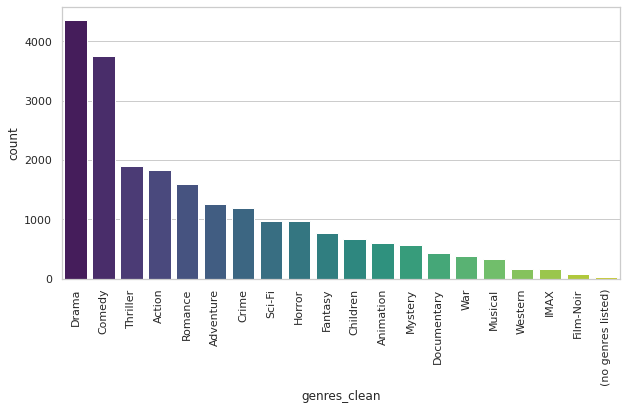

In [127]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres_clean', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres_clean', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

Ahora convirtamos el año en que salio la pelicula en una variable.  
Nota como el titulo de las peliculas contiene el año en que salieron:


In [128]:
movies.head()

,movieId,title,genres,genres_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


### Analisis y creacion de la varaible year

In [129]:
import re 

def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    if re.search(r'\(\d+\)', t[-1]):
        year = t[-1].strip('()')
        year = int(year)
    return year

In [130]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,genres_clean,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],1995.0


In [138]:
print(f"El numero de años es: {movies['year'].nunique()}")

El numero de años es: 106


Veamos los nulos

In [146]:
print(f"Peliculas despues de remover nulos {movies[~movies['year'].isnull()].shape}")

Peliculas despues de remover nulos (9718, 5)


Podemos removerlas sin alterar mucho nuestros datos

In [147]:
movies = movies[~movies['year'].isnull()]

In [ ]:
movies = movies[~movies['year'].isnull()]
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")

Veamos la distribucion 

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105]), <a list of 106 Text major ticklabel objects>)

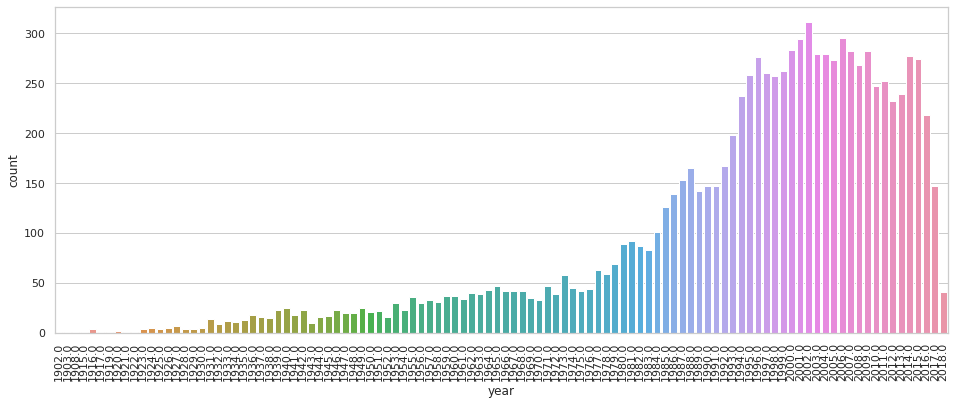

In [160]:
g = sns.countplot(movies['year'])
plt.xticks(rotation=90)

### Creacion de la variable Decada

Podriamos utilizar directamente el año como varaible, pero proponemos usar las decadas.

In [161]:
def round_down(year):
    return year - (year%10)

movies['decade'] = movies['year'].apply(round_down)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

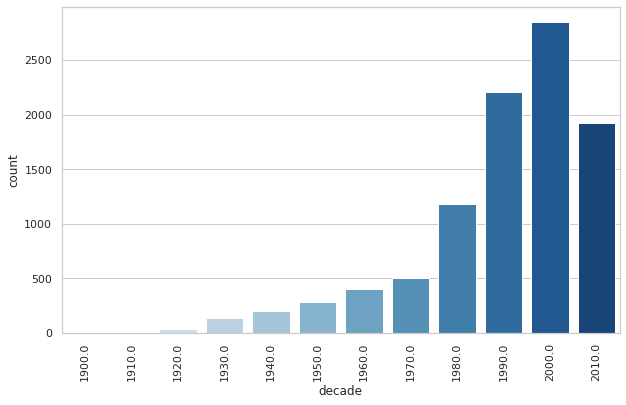

In [162]:
plt.figure(figsize=(10,6))
sns.countplot(movies['decade'], palette='Blues')
plt.xticks(rotation=90)

## FE

Convirtamos nuestra variable de genero a dummies

In [164]:
genres = list(genres_counts.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))
movies[genres].head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Hagamos lo mismo con nuestra variable de decadas

In [165]:
movie_decades = pd.get_dummies(movies['decade'])
movie_decades.head()

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


Ahora creemos un nuevo data set con nuestra ingenieria de variables

In [166]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed),1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Veamos la distribucion de los generos por pelicula. Por ejemplo, cuantos generos tiene cada pelicula?

In [212]:
movie_features[genres].sum(axis=1).describe()

count    9718.000000
mean        2.267442
std         1.123253
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
dtype: float64

Observamos que a lo mas una pelicula tiene 10 generos, y la mayoria tiene menos de tres.  
**Que pasaria si el numero de generos por pelicula fuera muy alto?**  
Bueno, pues en este caso nuestra variable de decada seria muy poco valiosa, pues su efecto se perderia en la inmensidad de generos. Lo contario pasa con peliculas que tienen pocos generos. Si quisieramos aumentar o ponderar mas la variable de **decada** bastaria con multiplicar esas columnas por un cierto valor.

## Modelo para Cold Start

Utilizaremos la distancia `cosine` al igual que en nuestro modelo anterior [cosine distance](https://es.wikipedia.org/wiki/Similitud_coseno).

Esta distancia compara el angulo entre dos vectores del espacio, entre mas grande es el angulo mayor es la distancia. Normalizada por el tamaño o dimensio de los vectores.  
Demanera que un angulo equivalente entre ambos de 180 grados la distancia seria 1, mientras que si su angulo es igual a 0 la distancia seria 0.

In [168]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimension de nuestra matriz de similaridad: {cosine_sim.shape}")

DImension de nuestra matriz de similaridad: (9718, 9718)


Ahora que ya tenemos nuestra matriz de similaridad entre peliculas, creemos nuestro recomendador con ayuda de la paqueteria **fuzzywuzzy** [paqueteria fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy).

La paqueteria de fuzzywuzzy nos permite encontrar strings similares, de esta manera no necesitamos conocer el nombre exacto de la pelicula solo un aproximado.

In [195]:
from fuzzywuzzy import process
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

Nota que la funcion de arriba sigue malas practicas, pues no estamos pasando como argumentos movies, la estamos usando como una varaible que existe fuera de nuestro scope de funcion. Hay que tener mucho cuidado de estos errores cuando estemos en produccion. Por ahora, tomemos licencia para ser un poco mas laxos, pues estamos en **piloto**.

In [204]:
# Diccionario con los nombres de las peliculas
movie_idx = dict(zip(movies['title'], list(movies.index)))

In [205]:
# Titulo de la pelicula
title = movie_finder('toy histry')
# Indice
idx = movie_idx[title]

# Recommendador
n_recommendations=10
# Scores de similaridad par ala pelicula que elegimos
sim_scores = list(enumerate(cosine_sim[idx]))
# Ordenamos de mayor a menor similaridad
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Toy Story (1995):


1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
559                                      Space Jam (1996)
1357                                Borrowers, The (1997)
1757                                 Bug's Life, A (1998)
2539                We're Back! A Dinosaur's Story (1993)
5624    Kirikou and the Sorceress (Kirikou et la sorci...
5975    Asterix & Obelix vs. Caesar (Astérix et Obélix...
6115                            Casper Meets Wendy (1998)
7759    Asterix in America (a.k.a Asterix Conquers Ame...
Name: title, dtype: object

Pasemos lo anterior a funcion

In [206]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Recommendations for {title}:")
    print(movies['title'].iloc[similar_movies])

In [207]:
get_content_based_recommendations('aladin', 5)

Recommendations for Aladdin (1992):
1177                                      Hercules (1997)
95                          Muppet Treasure Island (1996)
673     Land Before Time III: The Time of the Great Gi...
1757                                 Bug's Life, A (1998)
3727                Ferngully: The Last Rainforest (1992)
Name: title, dtype: object


# Modelaje con factorizacion de matrices

Ahora aprenderemos a construir nuestro recomendador usando descomposicion de amtrices. Esto es muy util cuando estamos manejando datos muy grandes, imagina tener 350 millones de usuarios, 3 millones de artistas, y 70 millones de canciones...  
Ante estas caracteristicas lo recomendable es reducir la dimensionalidad de nuestras matrices, una especie de PCA.

La descomposicion matricial nos puede ayudar a descubrir varaibles latentes que expliquen nuestros datos. Pueden ser interpretadas como gustos o preferencias de los usuarios, aunque llevar acabo una interpretacion puntual es un poco mas dificil. Pensemoslo mas como una abstraccion.

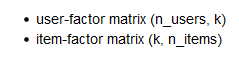

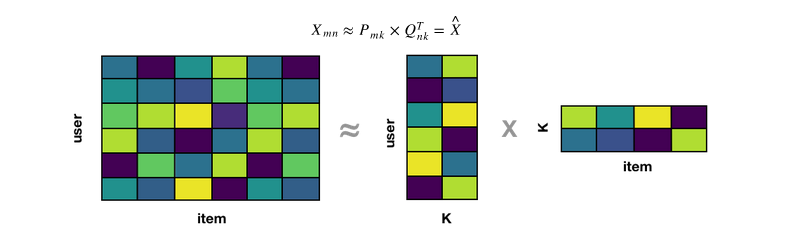

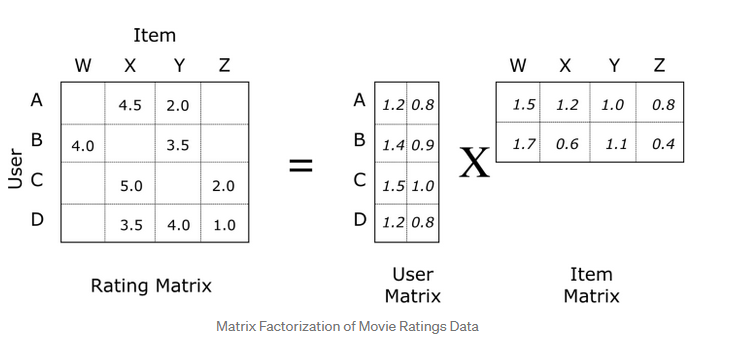

## SVD

Podemos hacer una primera descomposicion basandonos en SVD, que es parecido a PCA. La idea es la misma que en nuestro primer modelo de item-item, pero en vez de utilizar la matriz `X` utilizaremos una de dimencion reducida a traves de la descomposicion SVD.  



In [74]:
from sklearn.decomposition import TruncatedSVD

# Factoricemos nuestra matriz
# Recuerda que el numero de componentes puede cambiar
svd = TruncatedSVD(n_components=20, n_iter=10)
Z = svd.fit_transform(X)

# Ejemplo
movie_id = 1
similar_movies = find_similar_movies(movie_id, Z, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])



Because you watched Toy Story (1995):
Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Willy Wonka & the Chocolate Factory (1971)
Back to the Future (1985)
Forrest Gump (1994)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)
Babe (1995)


## ALS

Creemos unas funciones de ayuda de manera que estemos mas cerca de un codigo que podria llevarse a produccion:

In [225]:
def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

movie_title_mapper = dict(zip(movies['title'], movies['movieId']))
movie_title_inv_mapper = dict(zip(movies['movieId'], movies['title']))

def get_movie_index(title):
    fuzzy_title = movie_finder(title)
    movie_id = movie_title_mapper[fuzzy_title]
    movie_idx = movie_mapper[movie_id]
    return movie_idx

def get_movie_title(movie_idx): 
    movie_id = movie_inv_mapper[movie_idx]
    title = movie_title_inv_mapper[movie_id]
    return title

El metodo de `ALS` es computacionalmente mas ligero que la descomposicion SVD, por lo que tiende a usarse mucho en produccion.

Utilizaremos el paquete implicit, con su metodo `AlternatingLeastSquares` [ALS](https://implicit.readthedocs.io/en/latest/als.html).  
Esta descomposicion esta pensada para datos masivos por lo que tambien tiene su implementacion en pySpark.

### Item-Item

In [218]:
model = implicit.als.AlternatingLeastSquares(factors=50)

GPU training requires factor size to be a multiple of 32. Increasing factors from 50 to 64.


**Nota:** Puede que al ejecutar la celda anterior veas un mensaje como el de abajo

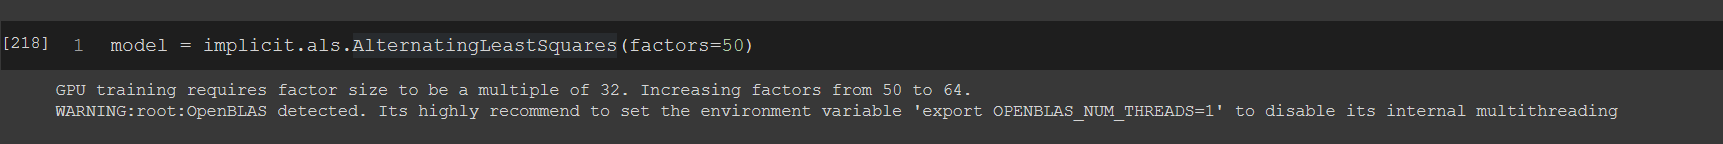

Este estilo de Warnings son de suma importancia. 
+ El primero te idicia que si estuvieras usando GPUs utilizaras multiplos de 32. Esto se debe a que la estructura de datos y hardware de NVIDIA viene en bloques de 32. Por defecto **implicit** utiliza GPU, por ello debemos pasar el parametro como falso.
+ Te esta indicando que ejecutes el comando `export OPENBLAS_NUM_THREADS=1` para evitar problemas.  
Lo que esta ocurriendo es que esta libreria usa la grandiosa, util y muy amada
 paqueteria de computo cientifico conocida como [OpenBlas](https://www.openblas.net/) como backend. Este backend tambien paraleliza pero entra en conflicto con la parelizacion de la paqueteria de python, de manera que provocaria problemas al saturar el numero de tareas paralelas que le pediria tu proceso a tu computadora, por ello es necesario poner la parelizacion de OpenBlas a 1 thread, y dejar que python lo maneje. De no hacerlo tu codigo podria tardar mucho mas en correr.

In [219]:
!export OPENBLAS_NUM_THREADS=1

[implicit.als.AlternatingLeastSquares](https://implicit.readthedocs.io/en/latest/als.html)

In [222]:
model = implicit.als.AlternatingLeastSquares(factors=50, use_gpu=False)

In [223]:
model.fit(X)

In [226]:
movie_of_interest = 'forrest gump'
movie_index = get_movie_index(movie_of_interest)
related = model.similar_items(movie_index)
related


[(314, 1.0),
 (277, 0.87614214),
 (257, 0.8459766),
 (510, 0.8453917),
 (97, 0.7728699),
 (461, 0.73308045),
 (418, 0.7231843),
 (123, 0.68771404),
 (43, 0.66691864),
 (508, 0.641523)]

Este output es poco interpetable pues solo vemos los indices de las peliculas, por lo anterior podemos usar la funcion que definimos antes conocida como `get_movie_title`.

In [227]:
print(f"Porque viste Forest Gump {movie_finder(movie_of_interest)}...")
for r in related:
    recommended_title = get_movie_title(r[0])
    if recommended_title != movie_finder(movie_of_interest):
        print(recommended_title)

Because you watched Forrest Gump (1994)...
Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Braveheart (1995)
Schindler's List (1993)
Jurassic Park (1993)
Apollo 13 (1995)
Seven (a.k.a. Se7en) (1995)
Dances with Wolves (1990)


### User-item

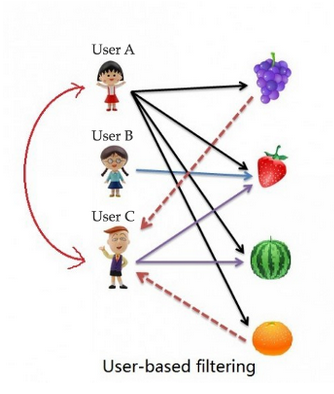

Ahora haremos uso de las funciones de recomendacion que se encuentran en la paqueteria de `implicit`.

Tomemos al usuario 95

In [229]:
user_id = 95

In [230]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
print(f"Numero de peliculas vistas por el usuario {user_id}: {user_ratings['movieId'].nunique()}")

Numero de peliculas vistas por el usuario 95: 168


Ahora veamos su Top 5 y Bottom 5

In [231]:
user_ratings = ratings[ratings['userId']==user_id].merge(movies[['movieId', 'title']])
user_ratings = user_ratings.sort_values('rating', ascending=False)
top_5 = user_ratings.head()
top_5

,userId,movieId,rating,timestamp,title
24,95,1089,5.0,1048382826,Reservoir Dogs (1992)
34,95,1221,5.0,1043340018,"Godfather: Part II, The (1974)"
83,95,3019,5.0,1043340112,Drugstore Cowboy (1989)
26,95,1175,5.0,1105400882,Delicatessen (1991)
27,95,1196,5.0,1043340018,Star Wars: Episode V - The Empire Strikes Back...


In [232]:
bottom_5 = user_ratings[user_ratings['rating']<3].tail()
bottom_5

,userId,movieId,rating,timestamp,title
93,95,3690,2.0,1043339908,Porky's Revenge (1985)
122,95,5283,2.0,1043339957,National Lampoon's Van Wilder (2002)
100,95,4015,2.0,1043339957,"Dude, Where's My Car? (2000)"
164,95,7373,1.0,1105401093,Hellboy (2004)
109,95,4732,1.0,1043339283,Bubble Boy (2001)


Basandonos en sus preferencias, podemos inferir que le gustan las peliculas de crimen y de accion, sobre todo de los 90s. Tiene cierto disgusto por las comedias.  
Veamos que recomendaciones emite el metodo `recommender` de `implicit`.

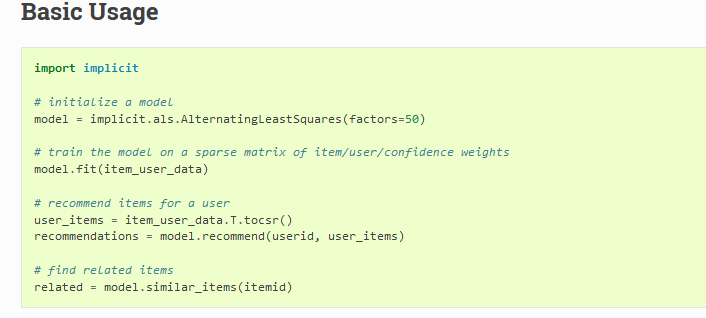

Si quieres saber como funciona el metodo de recommender tienes que acudir al codigo directo de github, pues no hay mucha documentacion al respecto.

**Tenemos que transponer la matriz de utilidad, pues ahora es user-item**.  
De tal manera que la matriz ahora si corresponde a su forma canonica: rows: usuarios, cols:rating de peliculas.

In [233]:
# Tenemos que transponer la matriz de utilidad, pues ahora es user-item
X_t = X.T.tocsr()

user_idx = user_mapper[user_id]
recommendations = model.recommend(user_idx, X_t)
recommendations

[(1210, 1.0608189),
 (898, 0.97667354),
 (1978, 0.95583385),
 (3633, 0.94863594),
 (855, 0.9168153),
 (1644, 0.8787383),
 (1223, 0.8638364),
 (915, 0.8565163),
 (1066, 0.83354384),
 (3136, 0.8196112)]

In [234]:
for r in recommendations:
    recommended_title = get_movie_title(r[0])
    print(recommended_title)

Hunt for Red October, The (1990)
Princess Bride, The (1987)
Star Wars: Episode I - The Phantom Menace (1999)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Abyss, The (1989)
Untouchables, The (1987)
Game, The (1997)
Army of Darkness (1993)
Jaws (1975)
Memento (2000)


En este caso un filtro user-item es mas facil de evaluar, pues podemos eliminar algunos ratings de nuestros usuarios, y ver que tan bueno es el modelo para predecirlo.

Podriamos ahcerlo en python, pero talvez solo talvez sea conveniente hacerlo en pySpark de esta manera podremos extrapolar el codigo para cuando tengamos datos muy grandes.

# ALS Recommender System en Spark

## Instalando Spark



Cuando hagas deployment en la nube o entres a produccion es muy importante que las versiones que utilices sean compatibles. Dado que Spark esta basado en Scala y utiliza librerias de Java es muy importante prestar atencion a las versiones!


In [236]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [237]:


# En la siguiente celda necesitaremos la direccion donde esta instalado
# nuestra version de spark
!ls /content/



sample_data  spark-2.4.7-bin-hadoop2.7	spark-2.4.7-bin-hadoop2.7.tgz


In [240]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

In [242]:
from pyspark.sql.functions import col, explode
from pyspark import SparkContext

## Iniciemos Spark Session

In [249]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

sc = SparkSession \
        .builder \
        .appName("recomendacion") \
        .getOrCreate()

## ETL

### Lectura de datos 

In [252]:
from pyspark import SparkFiles
# Agreguemos la direccion a nuestra sesion de spark
url = "https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/movies.csv"
sc.sparkContext.addFile(url)

# Leamos nuestro archivo
movies = sc.read.csv("file://"+SparkFiles.get("movies.csv"),
                 header="true")

In [253]:
url = "https://raw.githubusercontent.com/IEXE-Tec/mcda-marketing/main/ratings.csv"
sc.sparkContext.addFile(url)

# Leamos nuestro archivo
ratings = sc.read.csv("file://"+SparkFiles.get("ratings.csv"),
                 header="true")

In [254]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [255]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [257]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [259]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Manejo de tipos de ratings

In [256]:
ratings = ratings.\
    withColumn('userId', col('userId').cast('integer')).\
    withColumn('movieId', col('movieId').cast('integer')).\
    withColumn('rating', col('rating').cast('float')).\
    drop('timestamp')
ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



## EDA

### Sparsity

In [260]:
# Contemos el numero de observaciones en el dataset
numerator = ratings.select("rating").count()

# Numero de ids distintos
num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()

# Numero de celdas totales
denominator = num_users * num_movies

# Sparsity
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print(f"El sparcity de nuestros datos es {sparsity} % vacio")

El sparcity de nuestros datos es 98.30003169443864


### Exploracion de ids

In [261]:
# User ids
userId_ratings = ratings.groupBy("userId").count().orderBy('count', ascending=False)
userId_ratings.show()

+------+-----+
|userId|count|
+------+-----+
|   414| 2698|
|   599| 2478|
|   474| 2108|
|   448| 1864|
|   274| 1346|
|   610| 1302|
|    68| 1260|
|   380| 1218|
|   606| 1115|
|   288| 1055|
|   249| 1046|
|   387| 1027|
|   182|  977|
|   307|  975|
|   603|  943|
|   298|  939|
|   177|  904|
|   318|  879|
|   232|  862|
|   480|  836|
+------+-----+
only showing top 20 rows



In [262]:
# Movie ids
movieId_ratings = ratings.groupBy("movieId").count().orderBy('count', ascending=False)
movieId_ratings.show()

+-------+-----+
|movieId|count|
+-------+-----+
|    356|  329|
|    318|  317|
|    296|  307|
|    593|  279|
|   2571|  278|
|    260|  251|
|    480|  238|
|    110|  237|
|    589|  224|
|    527|  220|
|   2959|  218|
|      1|  215|
|   1196|  211|
|     50|  204|
|   2858|  204|
|     47|  203|
|    780|  202|
|    150|  201|
|   1198|  200|
|   4993|  198|
+-------+-----+
only showing top 20 rows



### Modelo ALS

In [263]:
# Funciones de spark para recomendador
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [264]:
# Separemos en Train y Test
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 1234)
# Creemos el modelo ALS
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

In [269]:
# Hagamos grid search de nuestros parametros
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()
           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Numero de modelos que estimaremos: ", len(param_grid))

Numero de modelos que estimaremos:  16


#### CV Pipeline

In [270]:
# Pipeline para CV
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

#### Entrenamiento

Puede que tarde mucho en correr de ser asi, te recomendamos modificar los parametros del grid.

In [ ]:
#Entrenemos
model = cv.fit(train)

#Tomemos el mejor modelo
best_model = model.bestModel

Analicemos el mejor modelo

In [ ]:
print(type(best_model))
print("**El mejor modelo**")
print("  Rank:", best_model._java_obj.parent().getRank())
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

In [ ]:
# Evaluemos las predicciones
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

In [ ]:
test_predictions.show()

### Generemos Recomendaciones

In [ ]:
# Generemos n recomendaciones
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

In [ ]:
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

#### Intuicion de las Recomendaciones

In [ ]:
nrecommendations.join(movies, on='movieId').filter('userId = 100').show()

In [ ]:
ratings.join(movies, on='movieId').filter('userId = 100').sort('rating', ascending=False).limit(10).show()